In [1]:
from __future__ import division
import os
import glob
import numpy as np
import cv2
from PIL import Image
import skimage
from skimage.transform import resize
from skimage.data import imread
import skimage.transform
from skimage.transform._warps_cy import _warp_fast
%matplotlib inline
from matplotlib.pyplot import  imshow
from time import time
from functools import partial
from math import sin, cos

import pdb
import pickle
import pandas as pd

In [3]:
train_dir='/home/ye/user/yejg/LEARN/DL_MODEL_LEARN/TensorFlow/TransferLearn/Fine_tune/data/train.txt'
val_dir='/home/ye/user/yejg/LEARN/DL_MODEL_LEARN/TensorFlow/TransferLearn/Fine_tune/data/val.txt'
image_size=224

In [4]:
def get_files(data_dir):
    #file=[]
    #for d in os.listdir(data_dir):
    #    dd=os.path.join(data_dir,d)
    #   for ddd in os.listdir(dd):
    #        file.append(os.path.join(dd,ddd))
    file=glob.glob('{}/*/*'.format(data_dir))
    return file

In [5]:
img_list=pd.read_csv(train_dir,header=None,sep=' ')
files=[str(x) for x in img_list.iloc[:,0]]
labels=[int(x) for x in img_list.iloc[:,1]]
print(files[:4])
print(labels[:4])

['/home/ye/user/yejg/database/Kaggle_Eye/train_001/train/11631_right.jpeg', '/home/ye/user/yejg/database/Kaggle_Eye/train_001/train/29953_right.jpeg', '/home/ye/user/yejg/database/Kaggle_Eye/train_001/train/37206_right.jpeg', '/home/ye/user/yejg/database/Kaggle_Eye/train_001/train/7213_right.jpeg']
[0, 0, 0, 0]


In [19]:
images_list=np.array([files,labels])
images_list=np.transpose(images_list)
np.random.shuffle(images_list)
print(images_list.shape)

(83986, 2)


In [20]:
files=[str(x) for x in images_list[:,0]]
labels=[int(x) for x in images_list[:,1]]

In [6]:
def fast_warp(img, tf, mode='constant', order=0):
    m = tf.params
    t_img = np.zeros(img.shape, img.dtype)
    for i in range(t_img.shape[0]):
        t_img[i] = _warp_fast(img[i], m, mode=mode, order=order)
    return t_img


def build_augmentation_transform(test=False):
    
    randst = np.random.mtrand.RandomState(int(time() % 3877))
    if not test:
        r = randst.uniform(-0.1, 0.1)  # scale
        rotation = randst.uniform(0, 2 * 3.1415926535)
        skew = randst.uniform(-0.2, 0.2) + rotation
    else: # only rotate randomly during test time
        r = 0
        rotation = randst.uniform(0, 2 * 3.1415926535)
        skew = rotation

    homogenous_matrix = np.zeros((3, 3))
    c00 = (1 + r) * cos(rotation)
    c10 = (1 + r) * sin(rotation)
    c01 = -(1 - r) * sin(skew)
    c11 = (1 - r) * cos(skew)

    # flip every other time
    if randst.randint(0, 2) == 0:
        c00 *= -1
        c10 *= -1

    homogenous_matrix[0][0] = c00
    homogenous_matrix[1][0] = c10
    homogenous_matrix[0][1] = c01
    homogenous_matrix[1][1] = c11
    homogenous_matrix[2][2] = 1


    transform = skimage.transform.AffineTransform(homogenous_matrix)
    return transform


def build_center_uncenter_transforms(image_shape):
    """
    These are used to ensure that zooming and rotation happens around the center of the image.
    Use these transforms to center and uncenter the image around such a transform.
    """

    # need to swap rows and cols here apparently! confusing!
    center_shift = np.array([image_shape[1], image_shape[0]]) / 2.0 - 0.5
    tform_uncenter = skimage.transform.SimilarityTransform(translation=-center_shift)
    tform_center = skimage.transform.SimilarityTransform(translation=center_shift)
    return tform_center, tform_uncenter


def augment(img, test=False):
    augment = build_augmentation_transform(test)
    center, uncenter = build_center_uncenter_transforms(img.shape[1:])
    transform = uncenter + augment + center
    img = fast_warp(img, transform, mode='constant', order=0)
    return img


def parallel_augment(images, normalize=None, test=False):
    if normalize is not None:
        mean, std = normalize
        images = images - mean[:, np.newaxis, np.newaxis] # assuming channel-wise normalization
        images = images / std[:, np.newaxis, np.newaxis]

    process = partial(augment, test=test)
    results =[process(img) for img in images]
    augmented_images = np.array(results, dtype=np.float32)
    return augmented_images

In [7]:
def load_images(file,image_size=224):
        image=cv2.imread(file)
        image=cv2.resize(image,(image_size,image_size))
        return image
    
def compute_edges(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.GaussianBlur(image, (11, 11), 0)
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0)
    sobel_x = np.uint8(np.absolute(sobel_x))
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1)
    sobel_y = np.uint8(np.absolute(sobel_y))
    edged = cv2.bitwise_or(sobel_x, sobel_y)
    return edged


def crop_image_to_edge(image, threshold=10, margin=0.2):
    edged = compute_edges(image)
    # find edge along center and crop
    mid_y = edged.shape[0] // 2
    notblack_x = np.where(edged[mid_y, :] >= threshold)[0]
    if notblack_x.shape[0] == 0:
        lb_x = 0
        ub_x = edged.shape[1]
    else:
        lb_x = notblack_x[0]
        ub_x = notblack_x[-1]
    if lb_x > margin * edged.shape[1]:
        lb_x = 0
    if (edged.shape[1] - ub_x) > margin * edged.shape[1]:
        ub_x = edged.shape[1]
    mid_x = edged.shape[1] // 2
    notblack_y = np.where(edged[:, mid_x] >= threshold)[0]
    if notblack_y.shape[0] == 0:
        lb_y = 0
        ub_y = edged.shape[0]
    else:
        lb_y = notblack_y[0]
        ub_y = notblack_y[-1]
    if lb_y > margin * edged.shape[0]:
        lb_y = 0
    if (edged.shape[0] - ub_y) > margin * edged.shape[0]:
        ub_y = edged.shape[0]
    cropped = image[lb_y:ub_y, lb_x:ub_x, :]
    return cropped


def crop_image_to_aspect(image, tar=1.2):
    # load image
    image_bw = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # compute aspect ratio
    h, w = image_bw.shape[0], image_bw.shape[1]
    sar = h / w if h > w else w / h
    if sar < tar:
        return image
    else:
        k = 0.5 * (1.0 - (tar / sar))
        if h > w:
            lb = int(k * h)
            ub = h - lb
            cropped = image[lb:ub, :, :]
        else:
            lb = int(k * w)
            ub = w - lb
            cropped = image[:, lb:ub, :]
        return cropped


def brighten_image_hsv(image, global_mean_v):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(image_hsv)
    mean_v = int(np.mean(v))
    v = v - mean_v + global_mean_v
    image_hsv = cv2.merge((h, s, v))
    image_bright = cv2.cvtColor(image_hsv, cv2.COLOR_HSV2RGB)
    return image_bright


def brighten_image_rgb(image, global_mean_rgb):
    r, g, b = cv2.split(image)
    m = np.array([np.mean(r), np.mean(g), np.mean(b)])
    brightened = image + global_mean_rgb - m
    return brightened


def image_pre_train(path,image_size,method='hsv'):

    if method=='hsv':
       vs=[]
       for f in path:
         image=load_images(f,image_size=image_size)

         image_hsv=cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
         h,s,v=cv2.split(image_hsv)
         vs.append(np.mean(v))

       return int(np.mean(np.array(vs)))

    if method=='rgb':
       mean_rgbs=[]
       for f in path:
           image=load_images(f,image_size=image_size)
        
           image_rgb=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
           r,g,b=cv2.split(image_rgb)
           mean_rgbs.append(np.array([np.mean(r),np.mean(g),np.mean(b)]))
       return np.mean(mean_rgbs,axis=0)



### load images

In [8]:
global_mean_rgb=image_pre_train(files[:8],image_size=224,method='rgb')
global_mean_hsv=image_pre_train(files[:8],image_size=224,method='hsv')

In [9]:
print(global_mean_hsv)
print(global_mean_rgb)

95
[94.93608747 65.04593331 43.7864766 ]


```python
feature_dict={'global_mean_rgb':global_mean_rgb,'global_mean_hsv':global_mean_hsv}
feature=open('features.pkl', 'wb')
data=pickle.dumps(feature_dict)
feature.write(data)
feature.close()
```

In [10]:
images=[load_images(file) for file in files[:8]]
images=np.array(images)

In [11]:
cropped_edge=crop_image_to_edge(image=images[0])
cropped_asp=crop_image_to_aspect(image=images[0])
brighten_hsv=brighten_image_hsv(image=images[0],global_mean_v=global_mean_hsv)
brighten_rgb=brighten_image_rgb(image=images[0],global_mean_rgb=global_mean_rgb)

In [12]:
print(cropped_asp.shape,cropped_edge.shape,brighten_hsv.shape,brighten_rgb.shape)

(224, 224, 3) (216, 199, 3) (224, 224, 3) (224, 224, 3)


(216, 199, 3)


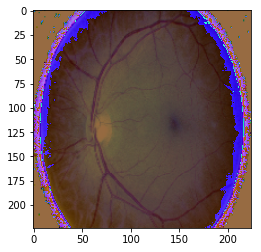

In [13]:
img=crop_image_to_edge(image=images[0])
img=crop_image_to_aspect(image=img)
img=brighten_image_hsv(image=img,global_mean_v=global_mean_hsv)
img=brighten_image_rgb(image=img,global_mean_rgb=global_mean_rgb)
imshow(cv2.resize((img+255)/255,(image_size,image_size)))
print((img+255).shape)

### batch iterator

In [35]:
class BatchIter(object):
    def __init__(self,image_list,batch_size,image_size=224,shuffle=True,
                features=None,ishandle=False):
        self.image_list=image_list
        self.batch_size=batch_size
        self.shuffle=shuffle
        self.image_size=image_size
        self.pointer=0
        self.features=features
        self.ishandle=ishandle
        self.shuffle_data()
        
    def __iter__(self):
        return self
    
    def __len__(self):
        return len(self.path)
    
    def  reset(self):
        self.pointer=0
        if self.shuffle:
            self.shuffle_data()
    
    def shuffle_data(self):
        if self.shuffle:
            np.random.shuffle(self.image_list)
        self.path=[str(x) for x in self.image_list[:,0]]
        self.labels=[int(x) for x in self.image_list[:,1]]
            
    def load_images(self,file):
        image=load_images(file=file,image_size=self.image_size)
        return image
    
    def handle(self,image):
        if self.features is not None:
            hsv,rgb=self.features[0],self.features[1]
        else:
            hsv=95
            rgb=[94.93608747,65.04593331,43.7864766]
        
        if np.random.random() < 0.5:
            img=cv2.flip(image,1)
        
        else:
            img=image
        # 定义卷积核 5x5
        kernel = np.ones((5,5), np.float32)/25
        img= cv2.filter2D(img,-1,kernel)
        
        img=cv2.GaussianBlur(img,(5,5),0)
        img=crop_image_to_edge(image=image)
        img=crop_image_to_aspect(image=img)
        img=brighten_image_hsv(image=img,global_mean_v=hsv)
        img=brighten_image_rgb(image=img,global_mean_rgb=rgb)
        img=(img+255)/255
        img=cv2.resize(img,(self.image_size,self.image_size))
            
        return img
                        
    def next(self):
        img=self.path[self.pointer:(self.pointer+self.batch_size)]
        images=[self.load_images(f) for f in img]
        images=np.array(images)
        labels=self.labels[self.pointer:(self.pointer+self.batch_size)]
        #self.pointer+=self.batch_size
        
     
                       
        if (self.pointer+self.batch_size)>len(self.path):
            images=[self.load_images(f) for f in self.path[self.pointer:]]
            images=np.array(images)
            labels=self.labels[self.pointer:]
            self.reset()
         
        if self.ishandle:
                images=[self.handle(img) for img in images]
                images=np.array(images)   
        self.pointer+=self.batch_size
        return images,labels

In [25]:
batchiterator=BatchIter(image_list=images_list[:8],batch_size=3,shuffle=False,ishandle=True)

6
[2, 3, 0, 2, 1, 1, 1, 0]


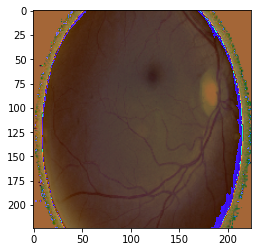

In [27]:
x=batchiterator.next()
print(batchiterator.pointer)
imshow(x[0])
print(batchiterator.labels)

In [28]:
from vgg16 import Vgg16
#import data_utils as du
#from data_utils import *
from sklearn.cross_validation import StratifiedShuffleSplit
import tensorflow as tf
import warnings
from sklearn import metrics
# ignore warning
warnings.filterwarnings("ignore")

/home/ye/user/yejg/SW_DATA/Or/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/ye/user/yejg/SW_DATA/Or/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [29]:
sss = StratifiedShuffleSplit(labels, n_iter=1, test_size=0.2, random_state=123)
train_idx, valid_idx = next(iter(sss))
images_list=images_list[valid_idx]
print(images_list.shape)

(16798, 2)


In [32]:
#  parameters
base_learning=1e-3
decay_rate=0.95
decay_step=200
num_example_per_epoch_for_train=len(images_list)
image_size=224
num_classes=5
max_epoch=100
print_step=10
save_step=50
val_step=50
batch_size=20

In [36]:
train_iter=BatchIter(image_list=images_list,batch_size=batch_size,ishandle=True,
                     features=(global_mean_hsv,global_mean_rgb),shuffle=True)

In [39]:
X=tf.placeholder(tf.float32,shape=[None,image_size,image_size,3])
y=tf.placeholder(tf.int64,shape=[None])
global_step = tf.Variable(0, trainable=False)


vgg16=Vgg16(batch_size=batch_size,image_size=image_size,learning_rate=base_learning,decay=decay_rate,decay_step=decay_step,
           num_example_per_epoch_for_train=num_example_per_epoch_for_train,num_classes=num_classes)
vgg16.inference(X)

prob=vgg16.prob
logits=vgg16.fc8
loss=vgg16.loss(logits=logits,labels=y)
accuracy=vgg16.accuracy(logits=logits,labels=y)
pred=vgg16.prediction()
train_op=vgg16.train(total_loss=loss,global_step=global_step)


# path
checkpoint_dir='./checkpoint'
tensorboard_dir='./tensorboard'
logs_train='./tensorboard/train'
logs_val='./tensorboard/val'
if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)

if not os.path.exists(tensorboard_dir):
    os.mkdir(tensorboard_dir)
    
if not os.path.exists(logs_train):
    os.mkdir(logs_train)
    
if not os.path.exists(logs_val):
    os.mkdir(logs_val)


*************** build the model **************
build model finished: 1s
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [ ]:
n_batch=len(train_iter)//batch_size
print('Traing........\n')
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver=tf.train.Saver(tf.global_variables())
    summary_op=tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(logs_train, sess.graph)
    val_writer = tf.summary.FileWriter(logs_val, sess.graph)
    
    for epoch in range(max_epoch):
        tra_acc=[]
        tra_loss=[]
        for iter in range(n_batch):
            tra_x,tra_y=train_iter.next()
            iter_start = time()
            
            sess.run([train_op],feed_dict={X:tra_x,y:tra_y})
            prediction,t_acc,t_loss,merged=sess.run([pred,accuracy,loss,summary_op],feed_dict={X:tra_x,y:tra_y})
            tra_acc.append(t_acc)
            tra_loss.append(t_loss)
            
            if (iter+1)%print_step==0:
                print('[epoch:%d/iter:%d]  minibatch(size:%d) train_loss: %.2f,accuracy: %.2f %%--Elapsed time: %.2fs' % (epoch, iter + 1,batch_size, t_loss,t_acc * 100.,
                                 time() - iter_start))
                print('---precision:%.4f,f1_score:%.4f,recall_score:%.4f---'%(metrics.precision_score(tra_y,prediction,average='macro'
                           ),metrics.f1_score(tra_y,prediction,average='macro'),metrics.recall_score(tra_y,prediction,average='macro')))

Traing........

